# Power Portfolio Build-Out Example with Linopy

This notebook provides a simplified example of building a power generation portfolio using `linopy`. The goal is to demonstrate the process of setting up and solving a linear optimization problem where different power generation resources are selected and built to meet future energy demands. 

In [86]:
import linopy as lp
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Problem Statement
This notebook presents an example portfolio expansion model used to meet an energy need.  This was originally developed for a hydropower utility.  Hydropower utilities can be energy limited (i.e., monthly energy balance) rather than capacity limited (i.e., hourly generating capacity), therefore, this algorithm addresses a monthly energy need rather than an hourly capacity need.  A different algorithm would be needed to meet capacity needs and would include battery storage, etc.   

This notebook addresses the question: what is the least-cost way to meet an energy need in the future?  

## Generate Dummy Data

A lot of this code is here just to generate dummy data.  I would not spend too much time on this code.  The `Linopy` model is down below.  
### Energy Need

This analysis assumes that an energy need has been identified through modeling and simulation.  For this example, we will assume the energy need is as follows:   

In [87]:
def generate_dummy_energy_needs(start_year=2024, years=10):
    # Generate a monthly date range
    dates = pd.date_range(start=f'{start_year}-01-01', periods=years*12, freq='M')
    
    # Create a sinusoidal pattern for energy needs with a downward trend over time
    months = np.arange(len(dates))
    
    # Base seasonal pattern using sine functions (with phase shift for winter, spring, etc.)
    seasonal_pattern = np.sin(2 * np.pi * (months % 12) / 12)  # Basic seasonal pattern (positive in spring/fall, negative in winter/summer)
    
    # Adjust the pattern so that winter months trend more negative over time
    winter_weight = 0.5 * (np.cos(2 * np.pi * (months % 12) / 12 - np.pi) + 1)  # Emphasize winter more
    
    # Add a downward trend over time
    trend = -0.01 * months  # A small negative trend each month
    
    # Combine seasonal pattern, winter weight, and trend
    energy_balance = seasonal_pattern * (1 - winter_weight) + trend
    energy_balance *= 10
    # Convert to pandas DataFrame
    df = pd.DataFrame(data={'monthly_energy_balance': energy_balance}, index=dates)
    
    return df


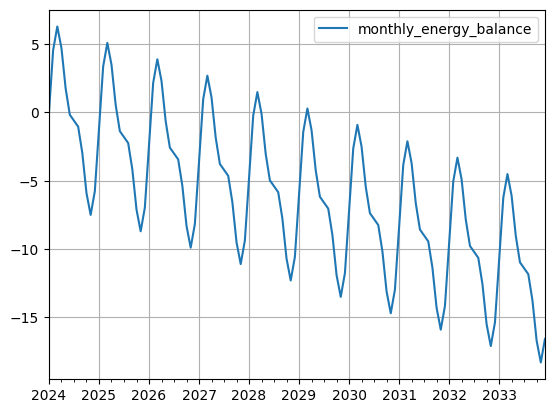

In [88]:
# Generate the dummy dataset
dummy_energy_needs_df = generate_dummy_energy_needs()
dummy_energy_needs_df.plot()
plt.grid()

The energy need is based on the negative monthly energy balance.  This will be an input to the model, so it needs to be put in an xarray.  

In [89]:
dummy_energy_needs_df.index.name = 'datetime'
dummy_energy_needs_df['energy_needs_aMW'] = (-dummy_energy_needs_df.monthly_energy_balance).clip(lower=0)
energy_needs_xr = xr.DataArray(dummy_energy_needs_df.energy_needs_aMW)

### Resource Generation Profiles

We are looking for the least cost resource that can meet the energy need.  We will make up some dummy generation profiles for wind and solar.  

In [90]:
def generate_resource_profiles(start_year=2024, years=10, noise_level=0.05):
    # Generate a monthly date range
    dates = pd.date_range(start=f'{start_year}-01-01', periods=years*12, freq='M')

    # Base profiles for wind and solar resources
    wind_winter_peak = np.array([0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.3, 0.4, 0.5, 0.55])  # Wind peaking in winter
    wind_summer_peak = np.array([0.3, 0.25, 0.3, 0.4, 0.5, 0.55, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35])  # Wind peaking in summer
    solar_base = np.array([0.1, 0.2, 0.4, 0.6, 0.7, 0.9, 0.95, 0.85, 0.6, 0.4, 0.2, 0.1])  # Solar peaking in summer

    # Create dummy profiles with slight variations
    profiles = {}
    for i, location in enumerate(['A', 'B', 'C']):
        # Set a unique random seed for each location's wind and solar profiles
        wind_seed = hash(f'wind_{location}') % (2**32)
        solar_seed = hash(f'solar_{location}') % (2**32)
        
        np.random.seed(wind_seed)
        if i == 0:
            wind_profile = wind_winter_peak + noise_level * np.random.randn(12)
        elif i == 1:
            wind_profile = wind_summer_peak + noise_level * np.random.randn(12)
        else:
            # Create a mix or a balanced profile as the third option
            wind_profile = 0.5 * (wind_winter_peak + wind_summer_peak) + noise_level * np.random.randn(12)
        
        np.random.seed(solar_seed)
        solar_profile = solar_base + noise_level * np.random.randn(12)
        
        # Set a unique random seed for the final noise adder
        np.random.seed(wind_seed + 1)
        profiles[f'wind_{location}'] = np.tile(wind_profile, years) + noise_level * np.random.randn(len(dates))

        np.random.seed(solar_seed + 1)
        profiles[f'solar_{location}'] = np.tile(solar_profile, years) + noise_level * np.random.randn(len(dates))

    # Create a DataFrame with the profiles
    df_profiles = pd.DataFrame(data=profiles, index=dates)
    
    return df_profiles


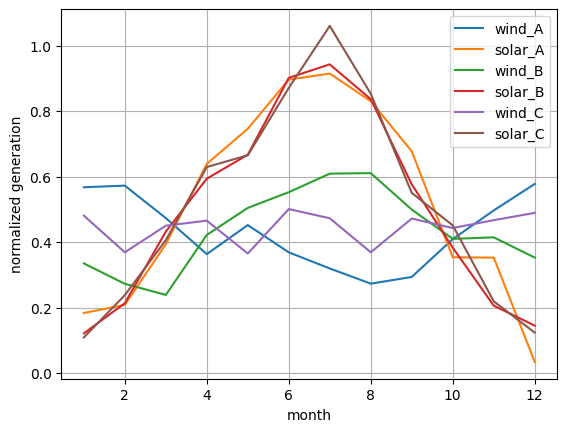

In [91]:
# Generate the dummy dataset
df_profiles = generate_resource_profiles()

# Plot the profiles for the first 12 months
df_profiles.groupby(df_profiles.index.month).mean().plot()
plt.xlabel('month')
plt.ylabel('normalized generation')
plt.grid()


As before, convert to xarray for linopy.  

In [92]:
df_profiles.index.name = 'datetime'
df_profiles.columns.name = 'resource'
resource_profiles_xr = xr.DataArray(df_profiles)

### Resource Cost Profiles

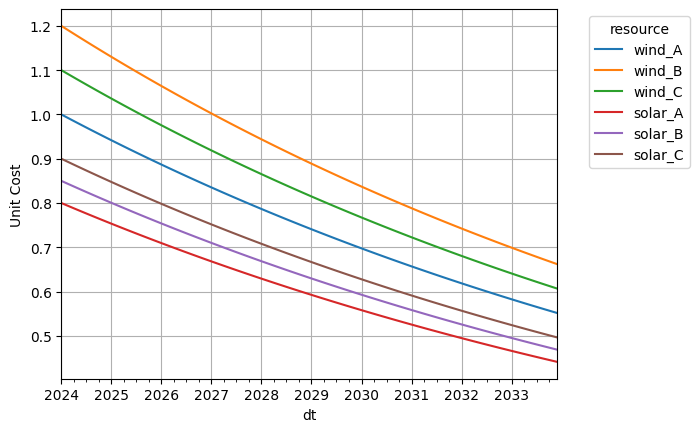

In [93]:
def generate_unit_cost_profiles(start_year=2024, years=10, decay_rate=0.005):
    # Generate a monthly date range
    dates = pd.date_range(start=f'{start_year}-01-01', periods=years*12, freq='M')
    
    # Initial costs for wind and solar resources
    initial_costs = {
        'wind_A': 1.0,
        'wind_B': 1.2,
        'wind_C': 1.1,
        'solar_A': 0.8,
        'solar_B': 0.85,
        'solar_C': 0.9,
    }
    
    # Create dummy profiles with slow exponential decay
    profiles = {}
    for resource, initial_cost in initial_costs.items():
        # Exponential decay function
        decay = initial_cost * np.exp(-decay_rate * np.arange(len(dates)))
        
        # Assign decay curve to profile
        profiles[resource] = decay
    
    # Create a DataFrame with the profiles
    df_profiles = pd.DataFrame(data=profiles, index=dates)
    
    return df_profiles

# Generate the dummy dataset
df_unit_cost_profiles = generate_unit_cost_profiles()

# Plot the unit cost profiles
df_unit_cost_profiles.plot()
plt.xlabel('dt')
plt.ylabel('Unit Cost')
plt.legend(title='resource', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()


Convert to xarray

In [94]:
df_unit_cost_profiles.index.name = 'datetime'
df_unit_cost_profiles.columns.name = 'resource'
unit_cost_profiles_xr = xr.DataArray(df_unit_cost_profiles)

## Optimized Energy Portfolio Model

Now we are finally to the porfolio model.  We know our resource needs, the generation of each resource, and the cost of each resource, we can write an optimization model to select the least cost portfolio that meets the energy need.  

The model is contained in the cells below.  I've broken up the code across cells so you can get an idea of what the model components look like.  Because the variables are vectorized across multiple dimensions, a single constraint is actually a whole array of constraints.      

In [95]:
# Initialize the model
m = lp.Model()

In [96]:
# build out
build_out = m.add_variables(lower=0, dims=resource_profiles_xr.dims,
                            coords=resource_profiles_xr.coords, name='build_out')
## make the build-out increase
m.add_constraints(build_out >= build_out.shift(datetime=1), name='build_out_increasing')

Constraint `build_out_increasing` (datetime: 120, resource: 6):
---------------------------------------------------------------
[2024-01-31 00:00:00, wind_A]: +1 build_out[2024-01-31 00:00:00, wind_A]                                               ≥ -0.0
[2024-01-31 00:00:00, solar_A]: +1 build_out[2024-01-31 00:00:00, solar_A]                                             ≥ -0.0
[2024-01-31 00:00:00, wind_B]: +1 build_out[2024-01-31 00:00:00, wind_B]                                               ≥ -0.0
[2024-01-31 00:00:00, solar_B]: +1 build_out[2024-01-31 00:00:00, solar_B]                                             ≥ -0.0
[2024-01-31 00:00:00, wind_C]: +1 build_out[2024-01-31 00:00:00, wind_C]                                               ≥ -0.0
[2024-01-31 00:00:00, solar_C]: +1 build_out[2024-01-31 00:00:00, solar_C]                                             ≥ -0.0
[2024-02-29 00:00:00, wind_A]: +1 build_out[2024-02-29 00:00:00, wind_A] - 1 build_out[2024-01-31 00:00:00, wind_A] 

In [97]:
#  gen
## multiply for each resource
gen = resource_profiles_xr * build_out 
## sum across resources
total_gen = gen.sum(dim='resource')

# Meet energy need
m.add_constraints(total_gen >= energy_needs_xr, name='meet_energy_need')

Constraint `meet_energy_need` (datetime: 120):
----------------------------------------------
[2024-01-31 00:00:00]: +0.5865 build_out[2024-01-31 00:00:00, wind_A] + 0.08098 build_out[2024-01-31 00:00:00, solar_A] + 0.2997 build_out[2024-01-31 00:00:00, wind_B] + 0.2 build_out[2024-01-31 00:00:00, solar_B] + 0.3958 build_out[2024-01-31 00:00:00, wind_C] + 0.09292 build_out[2024-01-31 00:00:00, solar_C]    ≥ -0.0
[2024-02-29 00:00:00]: +0.5446 build_out[2024-02-29 00:00:00, wind_A] + 0.2505 build_out[2024-02-29 00:00:00, solar_A] + 0.1823 build_out[2024-02-29 00:00:00, wind_B] + 0.2713 build_out[2024-02-29 00:00:00, solar_B] + 0.4301 build_out[2024-02-29 00:00:00, wind_C] + 0.2522 build_out[2024-02-29 00:00:00, solar_C]   ≥ -0.0
[2024-03-31 00:00:00]: +0.4962 build_out[2024-03-31 00:00:00, wind_A] + 0.4498 build_out[2024-03-31 00:00:00, solar_A] + 0.3503 build_out[2024-03-31 00:00:00, wind_B] + 0.4887 build_out[2024-03-31 00:00:00, solar_B] + 0.4543 build_out[2024-03-31 00:00:00, wind_C

In [98]:
# cost
build_month = build_out - build_out.shift(datetime=1)
cost = build_month * unit_cost_profiles_xr
total_cost = cost.sum()
total_cost


LinearExpression
----------------
+1 build_out[2024-01-31 00:00:00, wind_A] + 0.8 build_out[2024-01-31 00:00:00, solar_A] + 1.2 build_out[2024-01-31 00:00:00, wind_B] ... -0.6067 build_out[2033-11-30 00:00:00, wind_C] + 0.4964 build_out[2033-12-31 00:00:00, solar_C] - 0.4964 build_out[2033-11-30 00:00:00, solar_C]

In [99]:
# objective
m.add_objective(total_cost)
m

Linopy LP model

Variables:
----------
 * build_out (datetime, resource)

Constraints:
------------
 * build_out_increasing (datetime, resource)
 * meet_energy_need (datetime)

Status:
-------
initialized

# Solve

In [100]:
m.solve()

('ok', 'optimal')

In [101]:
sol = m.solution

Text(0.5, 1.0, 'Least Cost Energy Portfolio')

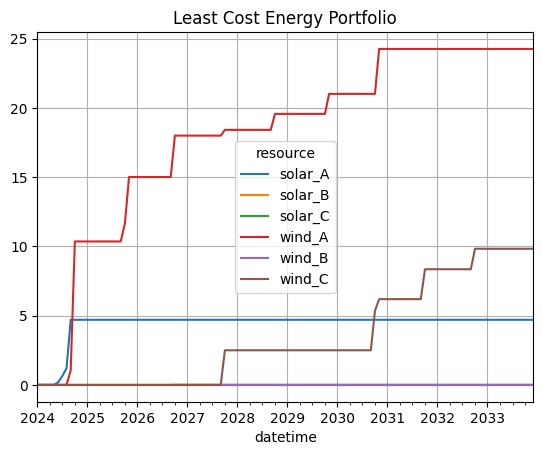

In [102]:
# convert to a Pandas DataFrame for plotting 
sol_df = sol.to_dataframe().reset_index().pivot_table(values='build_out', columns='resource', index='datetime')
sol_df.plot()
plt.grid()
plt.title('Least Cost Energy Portfolio')

We see that a mix a resources are the least cost way to meet the average energy need.  

## Concusion
Linopy's vectorized variables and constraints allow for a concise representation of an optimization problen with multiple dimensions: in this case, a timeseries with a number of potential resources.   